# Loss with a validation set

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, image, plotting
from nilearn.image import get_data

In [10]:
n_subjects = 2

contrasts = [
    "sentence reading vs checkerboard",
    "sentence listening",
    "calculation vs sentences",
    "left vs right button press",
    "checkerboard",
]
n_training_contrasts = 3

brain_data = datasets.fetch_localizer_contrasts(
    contrasts,
    n_subjects=n_subjects,
    get_anats=True,
)

source_imgs_paths = brain_data["cmaps"][0 : len(contrasts)]
target_imgs_paths = brain_data["cmaps"][len(contrasts) : 2 * len(contrasts)]

/opt/homebrew/lib/python3.11/site-packages/nilearn/datasets/func.py:763: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [11]:
source_im = image.load_img(source_imgs_paths)
target_im = image.load_img(target_imgs_paths)
source_features = np.nan_to_num(source_im.get_fdata())
target_features = np.nan_to_num(target_im.get_fdata())

SCALE_FACTOR = 4

source_features = source_features[::SCALE_FACTOR,::SCALE_FACTOR,::SCALE_FACTOR]
target_features = target_features[::SCALE_FACTOR,::SCALE_FACTOR,::SCALE_FACTOR]
data = source_features[:,:,:,0] !=0


source_features = source_features[data].T
target_features = target_features[data].T

## Compute distance matrix

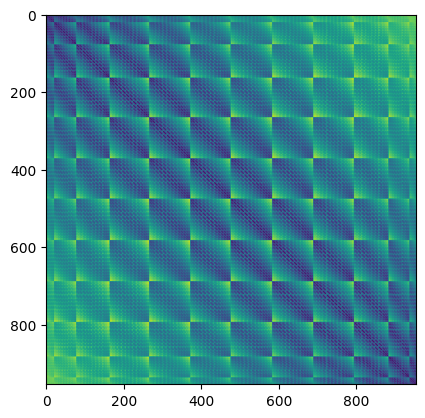

In [12]:
from scipy.spatial import distance_matrix
mat = np.array(np.nonzero(data)).T
source_geometry = distance_matrix(mat, mat)
target_geometry = source_geometry.copy()
plt.imshow(source_geometry)

In [13]:
# Normalization
source_features_normalized = source_features / np.linalg.norm(
source_features, axis=1
).reshape(-1, 1)
target_features_normalized = target_features / np.linalg.norm(
    target_features, axis=1
).reshape(-1, 1)
source_geometry_normalized = source_geometry / np.max(source_geometry)
target_geometry_normalized = target_geometry / np.max(target_geometry)

source_features_val = source_features_normalized[n_training_contrasts:]
target_features_val = target_features_normalized[n_training_contrasts:]

In [14]:
# Mapping training
from fugw.mappings import FUGW
mapping = FUGW(alpha=0.5, rho=1, eps=1e-4)
_ = mapping.fit(
    source_features_normalized[:n_training_contrasts],
    target_features_normalized[:n_training_contrasts],
    source_geometry=source_geometry_normalized,
    target_geometry=target_geometry_normalized,
    source_features_val=source_features_val,
    target_features_val=target_features_val,
    solver="sinkhorn",
    solver_params={
        "nits_bcd": 3,
    },
    verbose=True,
)

Output()

Output()

[18:17:55] BCD step 1/3    FUGW loss:      0.02198948711156845 (base)      Validation loss:            ]8;id=248939;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py\dense.py]8;;\:]8;id=508010;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py#375\375]8;;\
           0.022717876359820366 (base)     0.022801296785473824 (entropic)                                         

Output()

Output()

[18:18:01] BCD step 2/3    FUGW loss:      0.0029886572156101465 (base)    Validation loss:            ]8;id=789926;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py\dense.py]8;;\:]8;id=23540;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py#375\375]8;;\
           0.002938345540314913 (base)     0.00418081833049655 (entropic)                                          

Output()

Output()

[18:18:07] BCD step 3/3    FUGW loss:      0.002851981669664383 (base)     Validation loss:            ]8;id=462810;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py\dense.py]8;;\:]8;id=178949;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py#375\375]8;;\
           0.002687061671167612 (base)     0.00406305305659771 (entropic)                                          

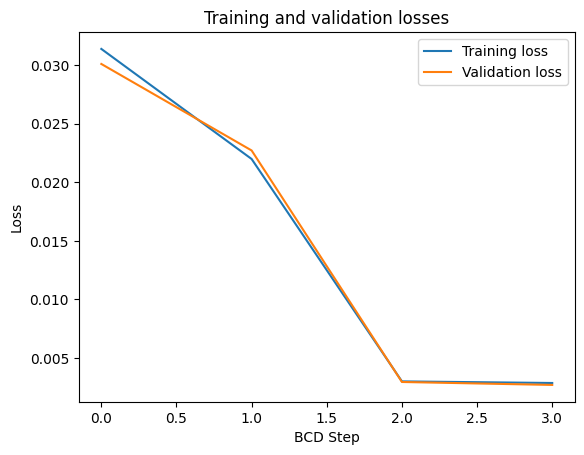

In [15]:
plt.plot(mapping.loss_steps, mapping.loss, label="Training loss")
plt.plot(mapping.loss_steps, mapping.loss_val, label="Validation loss")
plt.legend()
plt.title("Training and validation losses")
plt.xlabel("BCD Step")
plt.ylabel("Loss")
plt.show()